In [1]:
from NotebookLib import *
import GateSimulation
GateSimulation  = reload(GateSimulation)
sim = GateSimulation.Simulation('O-x-O')

Initializing system O-x-O  ...
Constructing states and excitations...
Constructing ground and first-excited statespace...
Constructing gs_hamiltonian ...
Constructing e1_hamiltonian ...
Constructing interactions V_plus and V_minus ...
Constructing NJ_hamiltonian  ...
Inverting NJ_hamiltonian  ...


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


Constructing eff_hamiltonian and effective lindblad operators ...

System  O-x-O  initialized in 33.4 seconds.

Preparing Superoperator sub-class
Preparing Analytical sub-class

Done!


# Obtain grid(s) of performance

In [45]:
# Global Parameters 
kSweep = [0.95]   #[0.995]
CSweep = [10]     #[20,25,30]
SplitSweep = [10] #[3,5,10]

# Dimensions of first grid for optimization  --- Give odd numbers
DeNum = 5
DENum = 5
tgNum = 5

# Limits of the grid
## DE will be multiplied by  np.sqrt(C_val)/gamma_val
DE_min = 0.1 
DE_max = 2
tg_min = 0.9
tg_max = 1.1

## Using analytical

In [46]:
gamma_val = sim.parameters['gamma']

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 1
for (k, C_val , max_split) in AllParams:
    progressBar(CurrentNumberOfSimulations, TotalParamElems, barLength = 60)
    CurrentNumberOfSimulations +=1
    
    c_val = k/ (4-4*k)
    # Optimization Parameters  --- Give odd numbers
    # De
    DeSweep = np.linspace(0,max_split , num = DeNum)
    # DE
    
    DESweep = np.linspace(0.1 , 2 , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime
    
    tgSweep = np.linspace(0.90,1.10 , num = tgNum)

    ParamsSweep = [DeSweep ,DESweep,tgSweep ]
    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)

    
    sim.Analytical.obtain_gate_performance_hardware(C_val,c_val,max_split)


    def simulation_process(De_val,DE_val,tg_ratio ):
        
        
        ii = np.where( DeSweep == De_val)[0][0]
        jj = np.where( DESweep == DE_val)[0][0]
        kk = np.where( tgSweep == tg_ratio)[0][0]
        index = (ii , jj , kk)

        gate_time = sg.real( sim.Analytical.gate_time_hw.subs( De=De_val,  DE=DE_val,tgr = tg_ratio ) )
        p_success = sg.real(sim.Analytical.p_success_hw.subs( De=De_val, DE=DE_val, tgr = tg_ratio,tgs=gate_time))
        try:    
            fidelity = sg.real(sim.Analytical.fidelity_hw.subs( De=De_val,  DE=DE_val, c=c_val,tgr = tg_ratio,tgs=gate_time,pss=p_success ))
        except ValueError:
            fidelity = 0
        
        return gate_time , p_success , fidelity , index

    pool = mp.Pool()
    all_sweeps = product(DeSweep,DESweep,tgSweep)
    for (tg, ps,fid, index) in pool.starmap(simulation_process,all_sweeps):
        GateTime[index] = tg
        Psucc[index] = ps
        Fidelity[index] = fid
   
 
    Directory = f'OptimizationResults/Analytical/ResC{C_val}_k{k}_Spl{max_split}_e{DeNum}_E{DENum}_t{tgNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
    np.save(Directory+f'/Fidelity',Fidelity)
    np.save(Directory+f'/GateTime',GateTime)
    np.save(Directory+f'/Psucc',Psucc)


Progress: [----------------------------------------------------------->] 100 %


## Using superoperator simulations

In [47]:
gamma_val = sim.parameters['gamma']

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 0
for (k, C_val , max_split) in AllParams:
    #progressBar(CurrentNumberOfSimulations, TotalParamElems, barLength = 60)
    CurrentNumberOfSimulations +=1
    
    c_val = k/ (4-4*k)
    # Optimization Parameters  --- Give odd numbers
    # De
    DeSweep = np.linspace(0,max_split , num = DeNum)
    # DE
    
    DESweep = np.linspace(0.1 , 2 , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime
    
    tgSweep = np.linspace(0.90,1.10 , num = tgNum)

    ParamsSweep = [DeSweep ,DESweep,tgSweep ]
    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)


    def simulation_process(De_val,DE_val,tg_ratio ):
        
        
        ii = np.where( DeSweep == De_val)[0][0]
        jj = np.where( DESweep == DE_val)[0][0]
        kk = np.where( tgSweep == tg_ratio)[0][0]
        index = (ii , jj , kk)

        super_dict = {'C' : C_val ,'c': c_val,\
                'De': De_val ,'De0': De_val - max_split, \
                'DE': DE_val ,'tgr': tg_ratio}
        performance = sim.Superoperator.Simulate(super_dict , realistic = True)
        gate_time = performance['gate_time']
        p_success = performance['p_success']
        fidelity = performance['fidelity']

        return gate_time , p_success , fidelity , index

    pool = mp.Pool(1)
    all_sweeps = product(DeSweep,DESweep,tgSweep)
    count_tot = DeNum * DENum * tgNum
    count = 0 
    for (tg, ps,fid, index) in pool.starmap(simulation_process,all_sweeps):
        GateTime[index] = tg
        Psucc[index] = ps
        Fidelity[index] = fid
        
        
   
 
    Directory = f'OptimizationResults/Superoperator/ResC{C_val}_k{k}_Spl{max_split}_e{DeNum}_E{DENum}_t{tgNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
    np.save(Directory+f'/Fidelity',Fidelity)
    np.save(Directory+f'/GateTime',GateTime)
    np.save(Directory+f'/Psucc',Psucc)


# Plot result

<>:31: DeprecationWarning: invalid escape sequence \%
<>:32: DeprecationWarning: invalid escape sequence \%
<>:45: DeprecationWarning: invalid escape sequence \L
<>:45: DeprecationWarning: invalid escape sequence \D
<>:31: DeprecationWarning: invalid escape sequence \%
<>:32: DeprecationWarning: invalid escape sequence \%
<>:45: DeprecationWarning: invalid escape sequence \L
<>:45: DeprecationWarning: invalid escape sequence \D
<ipython-input-48-9dde25483041>:31: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$F='+ str(np.round(FidelityData[argm]*100,decimals=2))+'\%$\n'
<ipython-input-48-9dde25483041>:32: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$P_{succ}='+ str(np.round(PsuccData[argm]*100,decimals=2))+'\%$\n'
<ipython-input-48-9dde25483041>:45: DeprecationWarning: invalid escape sequence \L
  ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n $(\Delta

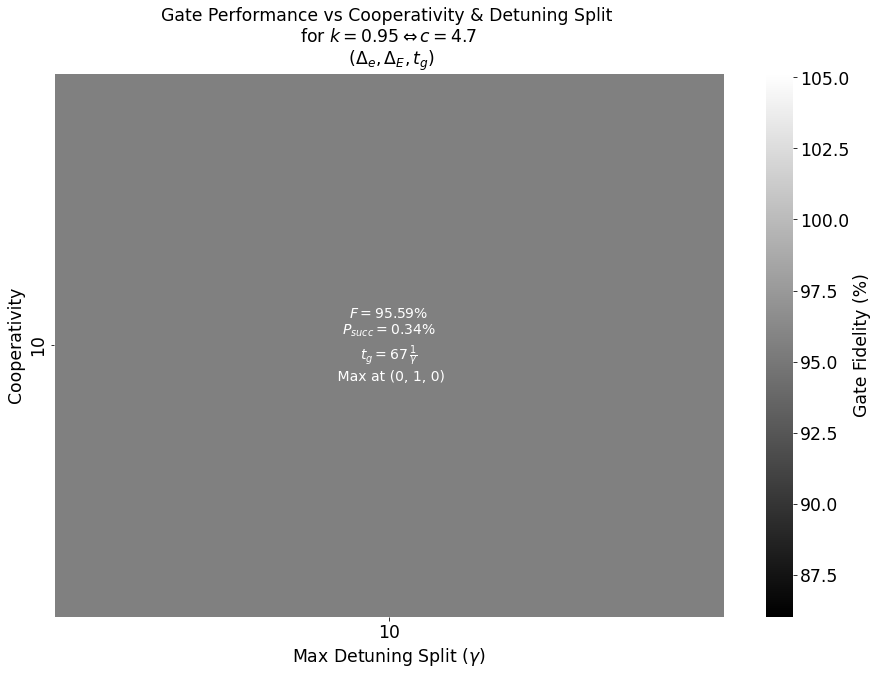

In [48]:
Analytical = False
kPlot = kSweep[0]
cPlot = kPlot / (4-4*kPlot)
'''
CSweep = [25,50,100]

SplitSweep = [3,5,10]

DeNum = 11
DENum = 11
tgNum = 11'''


if Analytical:
    subdir = 'Analytical'
else:
    subdir = 'Superoperator'
AllLabels = [["" for i in range(len(SplitSweep))]for j in range(len(CSweep))]
FidelityPlot = np.zeros(np.array(AllLabels).shape)
for (i,c) in enumerate(CSweep):
    for (j,spl) in enumerate(SplitSweep):
        DataDirectory = f'OptimizationResults/{subdir}/ResC{c}_k{kPlot}_Spl{spl}_e{DeNum}_E{DENum}_t{tgNum}/'
        GateTimeData = np.load(DataDirectory+"GateTime.npy")
        FidelityData = np.load(DataDirectory+"Fidelity.npy")
        PsuccData = np.load(DataDirectory+"Psucc.npy")


        argm = ArgMin( GateSimulation.gate_performance_cost_function(FidelityData,PsuccData,GateTimeData) ) 
        FidelityPlot[i][j] = FidelityData[argm]

        AllLabels[i][j] += '$F='+ str(np.round(FidelityData[argm]*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$P_{succ}='+ str(np.round(PsuccData[argm]*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$t_g='+ str(int(GateTimeData[argm]))+r' \,\frac{1}{\gamma}$'
        AllLabels[i][j] += f'\n Max at {argm}'
        


fig, ax = plt.subplots()


ax = sns.heatmap(FidelityPlot*100,yticklabels=CSweep,xticklabels=SplitSweep,cmap='gray', linewidth=0.5,annot=AllLabels, fmt = ''\
    ,cbar_kws={'label': 'Gate Fidelity (%)'}, annot_kws={"size": 14}) #Greys
ax.set_ylabel('Cooperativity')
ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n $(\Delta_e,\Delta_E,t_g)$')
plt.show() 
figure = ax.get_figure()
figure.savefig(f'plots/OptimizedHeatmap.svg',transparent=False)

In [49]:
init_params = [DeSweep[argm[0]],DESweep[argm[1]],tgSweep[argm[2]]]


In [50]:
sim.Analytical.optimize_gate_performance_hardware(init_params)
print(sim.Analytical.optimized_dict)

{'fidelity': 0.9500000014825066, 'p_success': 0.006407602673364953, 'gate_time': 63.26472990165107, 'tgr': 0.8544707039649844, 'De': 0.0003359685864994745, 'DE': 2.002095998067219}


In [51]:
sim.Analytical.hardware_dict

{'C': 10, 'c': 4.749999999999996, 'max_split': 10}

In [52]:
super = sim.Superoperator

super_variables = ['C','c','De','De0','DE','tgr']

super_dict = dict()
super_dict['De0'] =   sim.Analytical.optimized_dict['De'] - sim.Analytical.hardware_dict['max_split']
for param in super_variables:
    if param in sim.Analytical.hardware_dict:
        exec(f"super_dict['{param}'] = sim.Analytical.hardware_dict['{param}'] ")
    elif param in sim.Analytical.optimized_dict:
        exec(f"super_dict['{param}'] = sim.Analytical.optimized_dict['{param}'] ")

#super.realistic_parameters['gamma_g'] = 0.01
#super.realistic_parameters['gamma_f'] = 0.99
super.Simulate(super_dict,realistic = True)

{'fidelity': 0.9397938059482535,
 'p_success': 0.007463847623001284,
 'gate_time': 63.26472990165101}

In [53]:
super = sim.Superoperator
super.performance


{'fidelity': 0.9397938059482535,
 'p_success': 0.007463847623001284,
 'gate_time': 63.26472990165101}

In [54]:
super.performance

{'fidelity': 0.9397938059482535,
 'p_success': 0.007463847623001284,
 'gate_time': 63.26472990165101}

In [55]:
super.optimize_gate_performance_hardware(init_params , sim.Analytical.hardware_dict , max_iter = 10)

Cost function value: 0.0465828450969674 , fidelity=0.9558574444344584 , p_success=0.003417154903032645
Cost function value: 0.046581601217978094 , fidelity=0.9558662999839805 , p_success=0.003418398782021949
Cost function value: 0.045504385841845935 , fidelity=0.9534596902418987 , p_success=0.00449561415815411
Cost function value: 0.04741651090146593 , fidelity=0.9579326381058009 , p_success=0.0025834890985341153
Cost function value: 0.0517159178825457 , fidelity=0.9482840821174543 , p_success=0.005392257703709369
Cost function value: 0.04688051781283012 , fidelity=0.957557675798011 , p_success=0.003119482187169928
step = 1, (De,DE,tgr) = [0.         1.90922514 0.9       ] 
Cost function value: 0.04549320543196984 , fidelity=0.9526847156467844 , p_success=0.0045067945680302085
Cost function value: 0.05171591258062058 , fidelity=0.9482840874193794 , p_success=0.005392257703709595
step = 2, (De,DE,tgr) = [1.2500000e-04 1.8637674e+00 8.7750000e-01] 
Cost function value: 0.0450873417347653

In [56]:
super.performance

{'fidelity': 0.9500976811366649,
 'p_success': 0.005190089310267768,
 'gate_time': 66.39746052729153}

In [57]:
super.optimized_dict

{'fidelity': 0.9500976811366649,
 'p_success': 0.005190089310267768,
 'gate_time': 66.39746052729153,
 'tgr': 0.8961805555555553,
 'De': 0.00015624999999999998,
 'DE': 1.9525783536283885}

In [58]:
{'fidelity': 0.9492007096082482,
 'p_success': 2.0017765249499614e-05,
 'gate_time': 135.19739036377158,
 'tgr': 0.9310493827160492,
 'De': -0.0001691815272062186,
 'DE': 1.987627789557331}

{'fidelity': 0.9492007096082482,
 'p_success': 2.0017765249499614e-05,
 'gate_time': 135.19739036377158,
 'tgr': 0.9310493827160492,
 'De': -0.0001691815272062186,
 'DE': 1.987627789557331}